# Camera Calibration Scripts

In [1]:
%load_ext autoreload
%autoreload 2

## Image collection
Inspired by https://stackoverflow.com/questions/34588464/python-how-to-capture-image-from-webcam-on-click-using-opencv

6 -> left
14-> right
22 -> torso


In [5]:
import cv2
import numpy as np
import cv2 as cv
import glob
import time
from tqdm import tqdm
from copy import deepcopy
import scipy.optimize as sopt
from klampt.math import se3,so3
from itertools import combinations
import pickle

import open3d as o3d
from open3d_calibration import load_pc_dict
from calibration_utils import load_cam_K

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def make_1080p(cap):
    cap.set(3, 1920)
    cap.set(4, 1080)

cam1 = cv2.VideoCapture(6)
make_1080p(cam1)
cam2 = cv2.VideoCapture(14)
make_1080p(cam2)
cam3 = cv2.VideoCapture(22)
make_1080p(cam3)
cam_dict = {'realsense_left':cam1,'realsense_right':cam2,'realsense_torso':cam3}
curr_frame = {'realsense_left':[],'realsense_right':[],'realsense_torso':[]}
for i in cam_dict.keys():
    cv2.namedWindow(i)

img_counter = 0

while True:
    for camera in cam_dict.keys():
        cam = cam_dict[camera]
        ret, frame = cam.read()
        if not ret:
            print("failed to grab frame")
            break
        
        cv2.imshow(camera, cv2.resize(frame, (640,480)))
        curr_frame.update({camera:frame})
    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        for camera in cam_dict.keys():
            img_name = "./Calibration/data/{}/calib_image_frame_{}.png".format(camera,img_counter)
            cv2.imwrite(img_name, curr_frame[camera])
            print("{} written!".format(img_name))
        img_counter += 1

for camera in cam_dict.keys():
    cam_dict[camera].release()
# cam.release()

cv2.destroyAllWindows()

## intrinsic calibration:
following: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

In [ ]:

empty_dict = {'realsense_left':[],'realsense_right':[],'realsense_torso':[]}
# termination criteria

horizontal = 8
vertical = 6
size = 0.108
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((horizontal*vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:horizontal,0:vertical].T.reshape(-1,2)*size 
# Arrays to store object points and image points from all the images.
objpoints =  deepcopy(empty_dict)
imgpoints =  deepcopy(empty_dict) # 2d points in image plane.



In [ ]:
ok_dict = deepcopy(empty_dict)
for camera in ok_dict.keys():
    images = sorted(glob.glob('./Calibration/data/{}/calib_image_frame_*.png'.format(camera)))
    for fname in tqdm(images):
        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #     cv.imshow('webcam', gray)
    #     cv.waitKey()
        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (horizontal,vertical), None)
        ok_dict[camera].append(ret)
    #         cv.imshow('img', img)
    #         cv.waitKey(50)
    cv.destroyAllWindows()

In [ ]:
final_filter = np.zeros(len(ok_dict[list(ok_dict.keys())[0]]))
final_filter[:] = True
for i in ok_dict.keys():
    final_filter = np.logical_and(final_filter,ok_dict[i])
final_filter

In [ ]:
ok_dict = deepcopy(empty_dict)

for camera in ok_dict.keys():
    images = np.array(sorted(glob.glob('./Calibration/data/{}/calib_image_frame_*.png'.format(camera))))
    images = images[final_filter]
    for fname in tqdm(images):
        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #     cv.imshow('webcam', gray)
    #     cv.waitKey()
        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (horizontal,vertical), None)
        ok_dict[camera].append(ret)
    #     # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints[camera].append(objp)
            corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
            imgpoints[camera].append(corners)
            # Draw and display the corners
            cv.drawChessboardCorners(img, (horizontal,vertical), corners2, ret)
#             cv.imshow('img', img)
#             cv.waitKey(100)
    cv.destroyAllWindows()

In [ ]:
calibrations = deepcopy(empty_dict)
for camera in ok_dict.keys():
    
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints[camera], imgpoints[camera], gray.shape[::-1], None, None)
    calibrations.update({camera:[mtx,dist,rvecs,tvecs]})
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv.projectPoints(objpoints[camera][i], rvecs[i], tvecs[i], mtx, dist)
        error = cv.norm(imgpoints[camera][i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
        mean_error += error
    print( "total error for camera = {}: {}".format(camera,mean_error/len(objpoints)) )

## Extrinsic Calibration
from: https://docs.opencv.org/4.x/d7/d53/tutorial_py_pose.html

In [ ]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel().astype(int))
    img = cv.line(img, corner, tuple(imgpts[0].ravel().astype(np.int)), (255,0,0), 5)
    img = cv.line(img, corner, tuple(imgpts[1].ravel().astype(np.int)), (0,255,0), 5)
    img = cv.line(img, corner, tuple(imgpts[2].ravel().astype(np.int)), (0,0,255), 5)
    return img

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((horizontal*vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:horizontal,0:vertical].T.reshape(-1,2)*size
axis = np.float32([[2*size,0,0], [0,2*size,0], [0,0,-2*size]]).reshape(-1,3)

In [ ]:
corner = deepcopy(empty_dict)
rs = deepcopy(empty_dict)
ts = deepcopy(empty_dict)

for camera in ok_dict.keys():
    images = np.array(sorted(glob.glob('./Calibration/data/{}/calib_image_frame_*.png'.format(camera))))
    images = images[final_filter]
    mtx, dist, rvecs, tvecs = calibrations[camera]
    for fname in tqdm(images):
        
        img = cv.imread(fname)
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        ret, corners = cv.findChessboardCorners(gray, (horizontal,vertical),None)
        if ret == True:
            corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            # Find the rotation and translation vectors.
            ret,rvecs, tvecs = cv.solvePnP(objp, corners2, mtx, dist)
            rs[camera].append(rvecs)
            ts[camera].append(tvecs)
            # project 3D points to image plane
            imgpts, jac = cv.projectPoints(axis, rvecs, tvecs, mtx, dist)
            img = draw(img,corners2,imgpts)
            cv.imshow('img',img)
            k = cv.waitKey(0) & 0xFF
            if k == ord('l'):
                corner[camera].append('l')
            else:
                corner[camera].append('r')
#         if k == ord('s'):
#             cv.imwrite(fname[:6]+'.png', img)
cv.destroyAllWindows()

In [ ]:
corner_mask =  np.zeros(len(corner[list(ok_dict.keys())[0]]))
corner_mask[:] = True
for i in range(len(corner.keys())-1):
    this = list(corner.keys())[i]
    that = list(corner.keys())[i+1]
    equal = corner[this] == corner[that]
    corner_mask = np.logical_and(corner_mask,equal)
# corner_mask = np.array(corner['realsense']) == np.array(corner['webcam'])
compatibility_mask = final_filter.copy()
compatibility_mask[:] = False
compatibility_mask[final_filter] = corner_mask
final_mask = np.logical_and(final_filter,compatibility_mask)
final_mask

In [ ]:
m_rs = deepcopy(empty_dict)
m_ts = deepcopy(empty_dict)

for camera in ts.keys():
    m_rs.update({camera:np.array(rs[camera])[corner_mask].reshape(-1,3).tolist()})
    m_ts.update({camera:(np.array((ts[camera]))[corner_mask].reshape(-1,3)).tolist()})

In [ ]:
import scipy.optimize as sopt
from klampt.math import se3,so3
from itertools import combinations
import pickle

In [ ]:
def transformation_error(x,*args):
    """
    x:[0:6] pos + rotvec of one camera w.r.t. to the other
    """
    x = x.tolist()
    R_w_r = so3.from_rotation_vector(x[3:6])
#     print(R_w_r)
    T_w_r = x[:3]
    m1 = args[0]
    m2 = args[1]
#     print(T_w_r)
    errors = []
    for i,pt in enumerate(m1):
#         print(pt)
        pred_pt = se3.apply((R_w_r,T_w_r),pt)
        errors.append(np.linalg.norm(np.array(pred_pt)-np.array(m2[i])))
    
    return np.mean(errors)

In [ ]:
transforms = {}
for pair in combinations(m_rs.keys(), r =2):
    source = pair[0]
    destination = pair[1]
    res = sopt.minimize(transformation_error,np.array([0,0,0,1,0,0]),args = (m_ts[source],m_ts[destination]),tol = 0.0000001, options = {'maxiter':100000,'disp':True})
    transforms.update({tuple(pair):res.x})

In [ ]:
transforms
pickle.dump(transforms,open('./transforms.p','wb'))
pickle.dump(calibrations,open('./intrinsic_calibrations.p','wb'))

In [30]:
from realsense import RealSenseCamera


serial_numbers = {'realsense_left':"f0220315",'realsense_right':"f0271386",'realsense_torso':"f0190400"}

cams = {'realsense_left':[],'realsense_right':[],'realsense_torso':[]}
pt_clouds = deepcopy(cams)

for i in serial_numbers.keys():
    print(i)
    cams.update({i:RealSenseCamera(serial_numbers[i],'L515',{})})

realsense_left
Starting realsense L515 with extra settings
{}
realsense_right
Starting realsense L515 with extra settings
{}
realsense_torso
Starting realsense L515 with extra settings
{}


In [31]:
for i in serial_numbers.keys():
    print("serial number:", i)
    cams[i].update()
    pt_clouds.update({i:cams[i].latest_point_cloud()})

serial number: realsense_left
serial number: realsense_right
serial number: realsense_torso


In [32]:
pt_clouds['realsense_left']

array([[-0.        , -0.        ,  0.        ,  0.57647059,  0.50588235,
         0.41960784],
       [-0.        , -0.        ,  0.        ,  0.58039216,  0.50980392,
         0.42352941],
       [-0.        , -0.        ,  0.        ,  0.58431373,  0.50588235,
         0.42745098],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.01176471,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.00784314,
         0.00392157],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.00392157,
         0.        ]])

In [14]:
pt_clouds.keys()

dict_keys(['realsense_left', 'realsense_right', 'realsense_torso'])

In [33]:
pcd_dir = 'Calibration/data/point_cloud'
for k in pt_clouds.keys():
    pcd_fn = pcd_dir+'/'+k+'.npy'
    np.save(pcd_fn, pt_clouds[k])

In [4]:
pcd_dir = 'Calibration/data/point_cloud'
keys_list = ['realsense_left','realsense_right','realsense_torso']
pcd_dict = load_pc_dict(pcd_dir, keys_list)

pcd ary shape: (921600, 6)
pcd ary shape: (921600, 6)
pcd ary shape: (921600, 6)


In [5]:
pcd_dict.keys()

dict_keys(['realsense_left', 'realsense_right', 'realsense_torso'])

In [7]:
color_raw = o3d.io.read_image("Dataset/cam_left_imgs/color/color_1650418069209176274.png")
depth_raw = o3d.io.read_image("Dataset/cam_left_imgs/depth/depth_1650418069201362591.png")

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, 
                                                                depth_trunc=10.0,
                                                                convert_rgb_to_intensity=False)
print(rgbd_image)

RGBDImage of size 
Color image : 1920x1080, with 3 channels.
Depth image : 1920x1080, with 1 channels.
Use numpy.asarray to access buffer data.


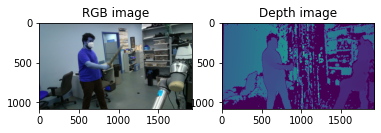

In [8]:
plt.subplot(1, 2, 1)
plt.title('RGB image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('Depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [9]:
K_fn = 'Calibration/data/intrinsics/intrinsic_calibrations.p'
cam_K_dict = load_cam_K(K_fn, 1920, 1080)

In [10]:
cam_K_dict['realsense_left'].intrinsic_matrix

array([[1.40716942e+03, 0.00000000e+00, 1.03449381e+03],
       [0.00000000e+00, 1.39827660e+03, 5.11012141e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [13]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, cam_K_dict['realsense_left'])
o3d.visualization.draw_geometries([pcd])

In [21]:
%run bag2png.py

PROCESS COMPLETE
